# CSINTSY MC01 - SokoBot Analyzer

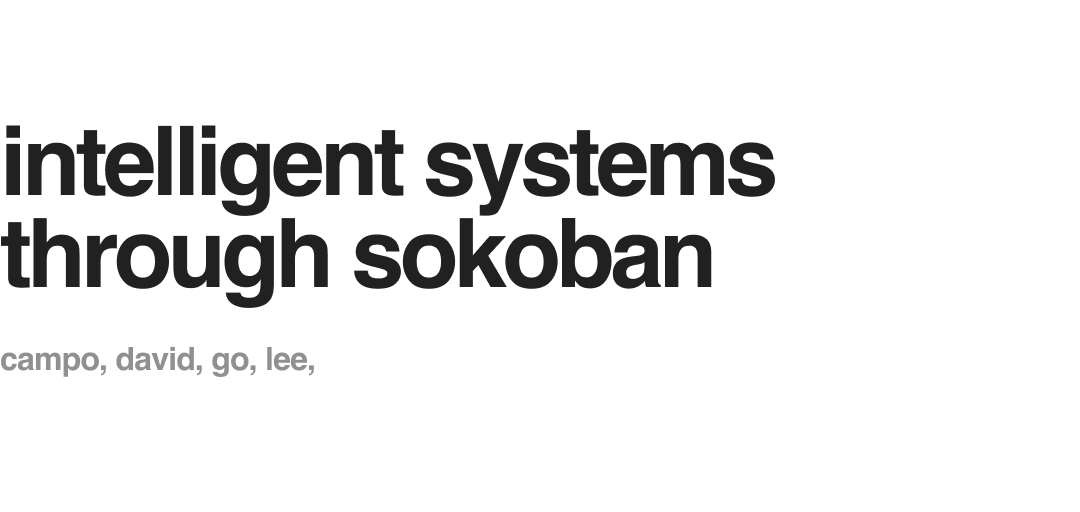

This Jupyter notebook file serves as a basis to analyze the efficiency of our group's sokobot.


## Preprocessing Modules
These are modules needed before running the analyzer. Please make sure to install the packages before running the analyzer.

To install packages, make sure you have the latest installation of pip and do `pip install x` where `x` is the name of the package required.

In [251]:
# Be sure to actually install the packages on your computer
# e.g. pip install pandas
import math
import warnings
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.widgets import Button
from IPython.display import display, Math
import matplotlib.ticker as mtick


# Some settings to help.
warnings.filterwarnings('ignore')
pd.set_option('display.width', 1000)
 

These are constants needed for the analysis to work. Some constants are there to help visualize the given data collected. 

You may change the settings of graphs look through here.

In [252]:
# The CSV file to import
CSV_FILE = "result_tests.csv"

# ANSI Escape code
RESET_COLORS = "\033[0m" 

# Some colors to pick out 
INFO_COLORS = {
    "test_name"             :"#ff63b7", 
    "test_file"             :"#ff6951", 
    "time_taken"            :"#ff8800",
    "no_of_move"            :"#fcaf00",
    "no_of_crates"          :"#acd100",
    "has_bot_won"           :"#00e75b",
    "solution"              :"#00edc4",
    "width_of_map"          :"#00e2ff",
    "height_of_map"         :"#00caff",
    "number_of_blocks"      :"#82abff",
    "child_nodes_made"      :"#d98dff",
    "nodes_expanded"        :"#ff74ff",
    "branching_factor"      :"#ea82ff",
    "map_density"           :"#3ac3ff",
    "has_bot_win_numeric"   :"#00e75b",
    "map_size"              :"#3a66ff"
}

INFO_NAMES = {
    "test_name"             : "Test name", 
    "test_file"             : "Test file", 
    "time_taken"            : "Time taken to solve",
    "no_of_move"            : "Number of moves",
    "no_of_crates"          : "Number of crates",
    "has_bot_won"           : "Boolean of bot wins",
    "solution"              : "Solution string",
    "width_of_map"          : "Map Width",
    "height_of_map"         : "Map Height",
    "number_of_blocks"      : "Number of blocks",
    "child_nodes_made"      : "New nodes created",
    "nodes_expanded"        : "Nodes processed",
    "branching_factor"      : "Branching factor",
    "map_density"           : "Map density",
    "has_bot_win_numeric"   : "Number of bot wins",
    "map_size"              : "Map Size",
    "log_nodes_expanded"    : "Logarithm of Node Expansion",
    "log_child_nodes_made"  : "Logarithm of Child Nodes Created",
    "log_no_of_move"        : "Logarithm of Solution Length",
    "log_map_size"          : "Logarithm of Map Size",
    "avg_node_creation_per_sec" : "Average node creation per sec",
    "avg_node_processed_per_sec" : "Average node processing per sec"
}

INFO_NICKNAMES = {
    "test_name"             : "Test name", 
    "test_file"             : "Test file", 
    "time_taken"            : "Time",
    "no_of_move"            : "Moves",
    "no_of_crates"          : "Crates",
    "has_bot_won"           : "Bot Wins",
    "solution"              : "Solution",
    "width_of_map"          : "Map width",
    "height_of_map"         : "Map height",
    "number_of_blocks"      : "Blocks",
    "child_nodes_made"      : "Child Nodes",
    "nodes_expanded"        : "Nodes Made",
    "branching_factor"      : "B factor",
    "map_density"           : "Map density",
    "has_bot_win_numeric"   : "Bot Wins",
    "log_nodes_expanded"    : "Log Nodes Made",
    "log_child_nodes_made"  : "Log Child Nodes",
    "log_no_of_move"        : "Log Solution Len",
    "log_map_size"          : "Log Map Size",
    "avg_node_creation_per_sec" : "Avg n created / sec",
    "avg_node_processed_per_sec" : "Ave n processed / sec"
}

# Additional colors to highlight colors
COLORS = {
    "RED"       : "#FF0000",
    "GREEN"     : "#00FF00"
}

STAT_NAME = {
    "mean"      : "Average",
    "median"    : "Median",
    "max"       : "Maximum",
    "min"       : "Minimum",
    "sum"       : "Summation"
}

### Coloring and Visualization
These functions help with analyzing data in a much visually significant way.

Not only that, it makes the graphs aesthetically pleasing to analyze.

In [253]:
# Colors text output of some functions.
def hex_to_rgb(hex_code: str) -> tuple[int, int, int]:
    """Turns hexcode to rgb

    Args:
        hex_code (str): hexcode that starts with #

    Returns:
        tuple(int, int, int): a tuple containing rgb information
    """
    hex_code = hex_code.lstrip('#')
    return tuple(int(hex_code[i:i + 2], 16) for i in (0, 2, 4))

def rgb_to_ansi_rgb(r, g, b):
    """Turns rgb values to ANSI escape codes

    Args:
        r (int): red
        g (int): green
        b (int): blue

    Returns:
        str: Equivalent Ansi Escape code.
    """
    return f"\033[38;2;{r};{g};{b}m"

def colored_text(hex_code) -> str:
    """colors text output 
    Args:
        hex_code (str): hexcode that starts with #

    Returns:
        str: Equivalent Ansi Escape code.
    """
    r, g, b = hex_to_rgb(hex_code)
    ansi_color = rgb_to_ansi_rgb(r, g, b)
    return ansi_color;

def rgb_to_hex(rgb: tuple[str, str, str]) -> str:
    """Generate a hexcode string from a rgb tuple

    Args:
        rgb (tuple[str, str, str]): 3-tuple representation of rgb values

    Returns:
        str: hexcode of the rgb values
    """
    return '#{:02x}{:02x}{:02x}'.format(rgb[0], rgb[1], rgb[2])

def mix_colors(hex_code1: str, hex_code2: str) -> str:
    """Mixes two colors together 

    Args:
        hex_code1 (str): string of color 1's hex code
        hex_code2 (str): string of color 2's hex code

    Returns:
        str: the mixed color's rgb code
    """
    # Unpack the RGB values
    r1, g1, b1 = hex_to_rgb(hex_code1)
    r2, g2, b2 = hex_to_rgb(hex_code2)
    
    # Average the RGB values
    mixed_color = (
        (r1 + r2) // 2, 
        (g1 + g2) // 2, 
        (b1 + b2) // 2
    )
    
    return rgb_to_hex(mixed_color)

def print_essay(essay: list[str]) -> None:
    """Concatenates a list of strings, then prints them in a single println statement.

    Args:
        essay (list[str]): List of sentences you want to output
    """
    output: str = str("");
    for sentence in essay:
        output += ('\n' + sentence);
    print(output)

def calculate_percent(partial: int, total: int):
    return (0, partial/total * 100)[total > 0]

def str_percentage_bar(partial: int, total: int, length = 30) -> str:
  percent = calculate_percent(partial, total)
  bar_length = int(length * percent // 100)
  full_char, empty_char  = '█', '-'
  
  str_bar: str =  (f'{colored_text(COLORS['GREEN'])}' + 
                   f'{full_char}' * bar_length + 
                   f'{colored_text(COLORS['RED'])}' + 
                   f'{empty_char}' * (length - bar_length) +
                   f'{(RESET_COLORS)}')
  
  return f'[{str_bar}]({percent: .2f} % )'


These sections contains helpful functions that preprocess the dataframe. A few can convert columns into analyzable data.


In [254]:
# Functions to preprocess the data.
def create_logs_of_colmn(df: pd.DataFrame, col_names: list[str]):
    """Create the logarithm of a list of column names

    Args:
        df (pd.DataFrame): dataframe to modify
        col_names (list[str]): list of strings to modify
    """
    for col_name in col_names:
        df["log_{}".format(col_name)] = df[col_name].agg(math.log)


def remove_seconds(input: str):
    """Used as an aggregate function to strip the seconds unit

    Args:
        input (str): numeric containing s at the end

    Returns:
        str: String with removed string unit
    """
    return input.rstrip("s"); 

def preprocess_df(df: pd.DataFrame) -> None:
    """Preprocesses dataframe for compatability. Turns the type of time_taken to float.

    Args:
        df (pd.DataFrame): dataframe to modify
    """
    # Time str into float
    df["time_taken"] = df["time_taken"].transform(remove_seconds)
    df["time_taken"] = df["time_taken"].astype(float);
    
    # Cleaning up
    df.loc[df['solution'].isin(["No solution found.", "Timed out."]), 'no_of_move'] = 0
    
    # Creation of other fields important
    df["branching_factor"] = df["child_nodes_made"] / df["nodes_expanded"]
    
    df["map_size"] = df ["width_of_map"] * df["height_of_map"]
    df["map_density"] = (df["map_size"]) / df["number_of_blocks"] 
    
    # Needed for correlation map as numerics are needed, not booleans
    df["has_bot_win_numeric"] = df["has_bot_won"].astype(int);
    
    # Logarithm 
    df["log_no_of_move"] = df["no_of_move"].agg(np.log10)
    df["log_child_nodes_made"] = df["child_nodes_made"].agg(np.log10)
    df["log_nodes_expanded"] = df["nodes_expanded"].agg(np.log10)
    df["log_map_size"] = df["map_size"].agg(np.log10)
    
    # Average Processing Speed
    df["avg_node_creation_per_sec"] = df["child_nodes_made"] / df["time_taken"]
    df["avg_node_processed_per_sec"] = df["nodes_expanded"] / df["time_taken"]


def sum_statistics(df: pd.DataFrame) -> None:
    """Summarizes some statistics per item and prints them.

    Args:
        df (pd.DataFrame): dataframe to modify
    """
    str_stats = ""
    
    for col, color in INFO_COLORS.items():
        sum_statistics.concat("\nStatistics of " + colored_text(color) + col + RESET_COLORS + ":\n")
        sum_statistics.concat("mean, median (min, max)\n{}, {} ({}, {})\n".format(
            round(df[col].agg("mean")   , 3),
            round(df[col].agg("median") , 3),
            round(df[col].agg("max")    , 3),
            round(df[col].agg("min")    , 3),
        ))
    print(str_stats) 
    
def bin_creation(df, info_type, nodes_group: int = 10, starting_index = 0):
  return [i * df[info_type].agg("max") / (nodes_group - 1) for i in range(starting_index, nodes_group)]

In [255]:
# Generates scatter plots

def generate_normal_scatter(df: pd.DataFrame, col_name: str, custom_color:str = ""):
    """Generates a pyplot scatter plot with the index as the x_axis and a column as the y_axis

    Args:
        df (pd.DataFrame): dataframe to inspect
        col_name (str): 
    """
    picked_color = (custom_color, INFO_COLORS[col_name])[not custom_color]
    ax = plt.scatter(df.index, 
                df[col_name], 
                s = 10, 
                alpha=0.5,
                color = picked_color);
    plt.xlabel("index");
    plt.ylabel(col_name);
    plt.title("Statistic for {}".format(col_name));
    plt.grid();
    plt.draw()
    return ax;

    
def genenerate_tuple_scatter(df: pd.DataFrame, col_tuple: tuple[str, str]):
    """Generates a pyplot graph with the col_tuple[0] as the x_axis and col_tuple[1] as the y_axis

    Args:
        df (pd.DataFrame): dataframe to plot from
        col_tuple (tuple[str, str]): tuple of strings that represent (x, y) values.
    """
    df.sort_values(col_tuple[0]);
    ax = plt.scatter(df[col_tuple[0]], 
                df[col_tuple[1]], 
                s = 10, 
                color = mix_colors(INFO_COLORS[col_tuple[0]], INFO_COLORS[col_tuple[1]]))
    plt.xlabel(col_tuple[0]) 
    plt.ylabel(col_tuple[1])
    plt.title("Statistic for {} vs {}".format(col_tuple[0], col_tuple[1]))
    plt.grid()
    return ax

def generate_3d_scatter(df: pd.DataFrame, tuple_col: tuple[str, str, str], cmap_col = ""):
    """Generate 3d scatter plot based on three Series, with the possible inclusion of a fourth one by domain coloring

    Args:
        df (pd.DataFrame): 
        tuple_col (tuple[str, str, str]):  tuple of strings that represent the names of series for (x, y, z) values.
        cmap_col (str, optional): string of the name of the series to do domain coloring. Defaults to "".
    """
    x = df[tuple_col[0]]
    y = df[tuple_col[1]]
    z = df[tuple_col[2]]
    w = df[cmap_col]

    # Creating figure
    fig = plt.figure(figsize = (16, 9))
    ax  = plt.axes(projection ="3d")
    
    # Add x, y gridlines 
    ax.grid(
        b = True, 
        color ='grey', 
        linestyle ='-.', 
        linewidth = 0.3, 
        alpha = 0.2
    ) 
    
    # Creating color map
    my_cmap = plt.get_cmap('hsv')
    
    
    # Creating plot
    sctt = ax.scatter3D(x, y, z,
                    alpha = 0.8,
                    c = w, 
                    cmap = my_cmap, 
                    marker ='^')
    
    plt.title("Statistics of {}, {}, {} and ".format(tuple_col[0], tuple_col[1], tuple_col[2]))
    ax.set_xlabel(tuple_col[0], fontweight ='bold') 
    ax.set_ylabel(tuple_col[1], fontweight ='bold') 
    ax.set_zlabel(tuple_col[2], fontweight ='bold')
    
    cbar = fig.colorbar(sctt, ax=ax, shrink=0.5, aspect=5)
    cbar.set_label(cmap_col, rotation=270, labelpad=20, fontweight='bold')  # Label the color bar

    # show plot
    plt.grid()
    plt.show()
    
def adjust_scatter_annotations(annotations: list[plt.annotate]):
    # Annotation adjustment
    for annotation in annotations:
        # Get bounding box
        bbox = annotation.get_window_extent()
        
        # Transform bounding box to coordinates on the graph
        ax = plt.gca()
        bbox_data = bbox.transformed(ax.transData.inverted())
        
        # Expand margins based on coordinates
        ax.update_datalim(bbox_data.corners())
        
        # Recalculate axis
        ax.autoscale_view()
        
def generate_annotations(pivot_table: pd.DataFrame, value_name: str, ax: plt.axes)-> list[mpl.text]:
    # Adding labels on top of the 'sum_of_wins' bars
    annotations = []
    for (index, series_partial) in pivot_table.iterrows():
        # Get the actual data
        partial = series_partial[value_name]
    
        # Create an annotation placed on the right of the bar graph
        annotation = ax.annotate(f'{round(partial,2)}', 
                    xy=(partial, index - 1),  # Use partial if no second graph, else get the actual percentage from the bigger graph
                    xytext=(5, 0),
                    va='center',
                    ha='left',
                    textcoords='offset points')
        annotations.append(annotation)
    return annotations

def groupby_bar_plot(df: pd.DataFrame, groupy_name: str, value_name: str, aggfunc: str = "mean"):
    df_col1_per_groupcol = df.pivot_table(index=groupy_name, values=value_name, aggfunc=aggfunc)

    # Plotting both the total maps and wins on the same graph
    ax = df_col1_per_groupcol.plot(kind='barh', legend=False, alpha=0.5, color=f'{INFO_COLORS[value_name]}', width=1)
    
    annotations = generate_annotations(df_col1_per_groupcol, value_name, ax);

    plt.title(f'{STAT_NAME[aggfunc]} {INFO_NAMES[value_name]} per {INFO_NAMES[groupy_name]}')
    plt.xlabel(f'{INFO_NAMES[value_name]}')
    plt.ylabel(f'{INFO_NAMES[groupy_name]}')
    plt.legend([f'{INFO_NAMES[value_name]}'], loc='upper left', bbox_to_anchor=(1, 1))

    # Show the updated plot
    plt.draw()
    adjust_scatter_annotations(annotations)


def bin_annotation(bin_df: pd.DataFrame, num_groups: int, indices: int, ax: plt.axes, colors: list[str] = []):
  bars = []

  bar_width = 0.6 / num_groups  # Adjusting the total width for the number of groups
  colors = plt.cm.get_cmap('Set1', num_groups) if len(colors) == 0 else colors  # Dynamically get colors from the colormap

  # e.g. bin_df.columns have ['True', 'False'] groups
  # iterate each group, 'True', and iterate each bar
  for i, group in enumerate(bin_df.columns):
      bar_positions = indices - (bar_width * num_groups) / 2 + i * bar_width
      
      if (len(colors) == 0):
        bar = ax.bar(bar_positions, bin_df[group], bar_width, label=group, color=colors(i))
      else:
        bar = ax.bar(bar_positions, bin_df[group], bar_width, label=group, color=colors[i])
        
      bars.append(bar)

      # Add annotations on top of each bar
      for rect in bar:
          yval = rect.get_height()
          ax.text(rect.get_x() + rect.get_width() / 2, yval, int(yval), ha='center', va='bottom')

def graph_binned_bar(df: pd.DataFrame, info_type: str, group_type: str, bins: list[str] = [0, 50, 100, 150, 200, 250, 300], colors = []):
  df_grouped_bins = df
  info_type_bin = f'{info_type}_bin'
  
  # Cut the values into bins
  df_grouped_bins[info_type_bin] = pd.cut(df[info_type], bins, include_lowest=True)  
    
    
  df_info_binned_group = df_grouped_bins.groupby([info_type_bin, group_type]).size().unstack(fill_value =0)
  
  # Set positions of the bars on the x-axis
  num_bins, num_groups  = len(df_info_binned_group), len(df_info_binned_group.columns)
  indices = np.arange(num_bins)

  fig, ax = plt.subplots()
  
  # add annoations to bins for their value
  bin_annotation(df_info_binned_group, num_groups, indices, ax, colors)
  
  # Add title and labels
  plt.title(f'Comparison by Binned {INFO_NAMES[info_type]}')
  plt.xlabel(f'{INFO_NAMES[info_type]} (Binned)')
  plt.ylabel(f'{INFO_NAMES[group_type]}')

  new_xticklabels = []
  for interval in df_info_binned_group.index:
      TICK_LIMIT = 5e5
      if interval.left >= TICK_LIMIT or interval.right >= TICK_LIMIT:
          new_xticklabels.append(f'({interval.left:.2e} - {interval.right:.2e}]')
      else:
          new_xticklabels.append(f'({interval.left:.2f} - {interval.right: .2f}]')

  # Add custom x-axis tick labels (the bin ranges)
  ax.set_xticks(indices)
  ax.set_xticklabels([f'{interval.left} - {interval.right}' for interval in df_info_binned_group.index])
  ax.set_xticklabels(new_xticklabels, rotation=45, ha='right', rotation_mode='anchor')

  plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
  plt.show()
  
def print_avg_std(df, info_type):
  mean = df[info_type].mean()
  std = df[info_type].std()
  print(f"{INFO_NAMES[info_type]}\nMean               : {mean}\nStandard Deviation : {std}\n")

# Analysis of Sokobot data
This portion deals with the analysis of the data that `tester.py` produces. 

It tests on 2750 different maps. Some maps are given my Ms. Shirley Chu from De La Salle University - Manila, while others are webscrapped from the internet. 

Tests where run on a computer with the following specs:

|Type                           |Information                                                                   |
|-------------------------------|------------------------------------------------------------------------------|
|OS and Manufacturer            |Windows 10, Microsoft Corporation                                             |
|System Type                    |x64-based PC                                                                  |
|Processor                      |AMD Ryzen 5 3500 6-Core Processor, 3600 Mhz, 6 Core(s), 6 Logical Processor(s)|
|Installed Physical Memory (RAM)|16.0 GB                                                                       |
|Graphics Processing Unit       |NVIDIA GeForce GTX 1660 SUPER                                                 |

First, preprocess the dataframe to clean the data and add necessary values. 

Then, separate them into two different groups: 
- when the Sokobot won and successfully created a solution, and 
- when the Sokobot lost and was timed out.

In [256]:
# Read the given CSV file within the same directory of the folder
df = pd.read_csv(CSV_FILE)

preprocess_df(df)
# Separate two different datasets
df_sucessful    = df[df["has_bot_won"] == True];
df_failed       = df[df["has_bot_won"] == False];

## Quick Overview of Data.
Here's a view of the data at first glance.

In [257]:
# Print the first few rows
print("Review some sample data from the database.\n")
print(df.head())


Review some sample data from the database.

  test_name test_file  time_taken  no_of_move  no_of_crates  has_bot_won                                           solution  width_of_map  height_of_map  number_of_blocks  ...  branching_factor  map_size  map_density  has_bot_win_numeric  log_no_of_move  log_child_nodes_made  log_nodes_expanded  log_map_size  avg_node_creation_per_sec  avg_node_processed_per_sec
0     base1     base1        0.08          25             2         True                          ldrrrurulddlllurrurulldlu             7              7                29  ...          1.833680        49     1.689655                    1        1.397940              2.945469            2.682145      1.690196               11025.000000                 6012.500000
1     base2     base2        0.08          18             2         True                                 drrrrulldlurrruull             8              7                32  ...          1.779449        56     1.750000          

In [258]:
# Describe the table
print("Some handy statistics of the dataframe:")
print(df.describe())

Some handy statistics of the dataframe:
        time_taken   no_of_move  no_of_crates  width_of_map  height_of_map  number_of_blocks  child_nodes_made  nodes_expanded  branching_factor     map_size  map_density  has_bot_win_numeric  log_no_of_move  log_child_nodes_made  log_nodes_expanded  log_map_size  avg_node_creation_per_sec  avg_node_processed_per_sec
count  2750.000000  2750.000000   2750.000000   2750.000000    2750.000000       2750.000000      2.750000e+03    2.750000e+03       2750.000000  2750.000000  2750.000000          2750.000000     2750.000000           2750.000000         2750.000000   2750.000000                2750.000000                 2750.000000
mean      9.059193    54.094909      7.880000     11.560000      10.570182         91.320364      1.060005e+06    7.049145e+05          1.440693   130.304000     1.407976             0.443273            -inf              5.421892            5.267970      2.049650              102561.635097                71685.390520
std

## Correlation Heatmap of values.
Correlation maps help distinguish what values has high likely hood to correlate with each other. 

By using Spearman's rank correlation coefficient, we can induce what possible correlation there is to the information gathered. 

Spearman is used rather than Pearson as it includes non-linear relationships asssuming they are monotonically increasing.

To classify the strength of correlation, we will use the following terms:
- ***Strong*** correlation. This is for values $v$ where it fits within the range $|v|\ge0.7$. Values that have a strong correlation must be investigated as it leads to interesting insight what factors in an intelligent system's success. 
- ***Moderate*** correlation. This is for values $v$ that fits the range of $0.3 \le |v|\le0.7$. There may be some worth dep 
- ***Weak*** correlation. $0\le|v|\le0.3$.

Axes(0.125,0.11;0.62x0.77)


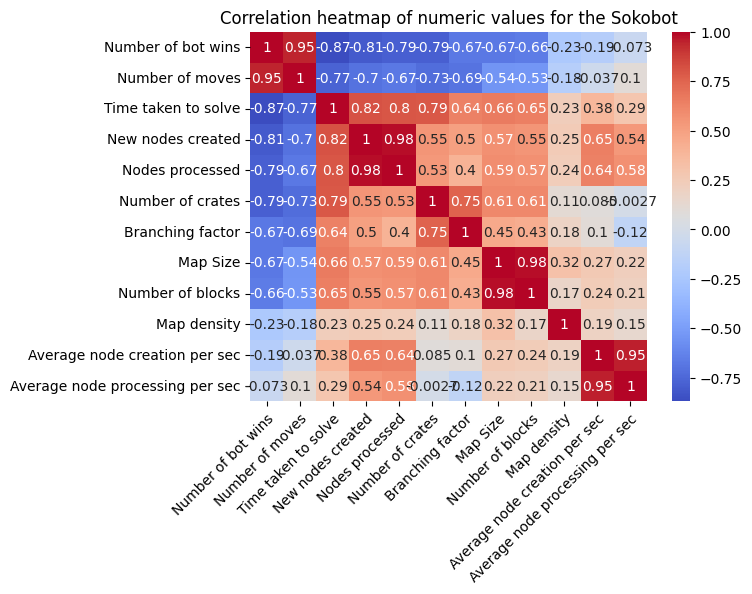

In [259]:
# Correlation map by Spearman
numeric_df = df[
    ["has_bot_win_numeric", 
     "no_of_move", 
     "time_taken", 
     "child_nodes_made", 
     "nodes_expanded", 
     "no_of_crates", 
     "branching_factor", 
     "map_size", 
     "number_of_blocks", 
     "map_density", 
     "avg_node_creation_per_sec",
     "avg_node_processed_per_sec"
     ]
]
numeric_df = numeric_df.rename(columns=INFO_NAMES)

corr_map_spearman = numeric_df.corr(method='spearman')

fig, ax = plt.subplots()
corr_heatmap = sns.heatmap(corr_map_spearman,
            annot=True,
            cmap=plt.get_cmap('coolwarm'),
            ax=ax,            
            )
ax.set_yticklabels(ax.get_yticklabels(), rotation="horizontal")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
plt.title("Correlation heatmap of numeric values for the Sokobot")

print(corr_heatmap)

Based on correlation map, we can choose which type of information to inspect for each factor that is worth to analyze.

Here are some pairs of types of informaton to inspect:
- Success Rate (Number of bot wins):
  - General i
  - Number of moves
  - Time taken to solve
  - New nodes created and nodes processed 
  - Crate Count
  - Map size
- Time Taken to solve:
  - General Information
  - Node Created
  - Node Processed
- Branching Factor:
  - Number of Crates

## Success rate 
Win rate measures the likelihood for the sokobot to find a solution within 15.0 seconds in a given map.

Based on the correlation map we have induce the possible factors that have a *strong* correlation:
| Type                                  | Reasoning                                                                                                                                                                           |
|---------------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Number of moves                       | It is a given since those with an actual solution have moves greater than zero. Thanks to data cleaning, we can gurantee that any timed out or impossible maps have a solution length of zero. Thus, it is intuitive to have direct relationship there.                                                       |
| Time taken to solve                   | The more time a bot needs to solve a problem, the less likely a map it is solvable given the time limit. An increase of difficulty of a map would naturally take longer to process. |
| New nodes created and nodes processed | The more information the bot needs to solve and process, the farther the goal is from the time limit.                                                                               |
| Crate Count                           | Increasing crate count increases difficulty to solve as you have more goals to keep track of to win.                                                                                |

There are also those with a *moderate* correlation that may be worth to check:
| Type                                  | Reasoning                                                                                                                                                                           |
|---------------------------------------|-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| Map Size                              | Increasing the map size increases the amount of tiles needed to be account by the program.                                                    |

The figures below describes likelihood to succeed in all of the maps tested:

In [260]:
# Overall in most games
essay_overall_wins = [
    "How many tests have sokobot won in General?",
    "{}Won{}      : {}".format(colored_text(COLORS["GREEN"]),  RESET_COLORS, str(df_sucessful.shape[0])),
    "{}Fail{}     : {}".format(colored_text(COLORS["RED"]), RESET_COLORS, str(df_failed.shape[0])),
    "---------+--------------------------------",
    "Win Rate : {}% of out of {} tests".format(str(round(df_sucessful.shape[0] / df.shape[0] * 100, 2)), str(df.shape[0])),
    f"{str_percentage_bar(partial=df_sucessful.shape[0], total=df.shape[0])}\n"
]

print_essay(essay_overall_wins)



How many tests have sokobot won in General?
Won      : 1219
Fail     : 1531
---------+--------------------------------
Win Rate : 44.33% of out of 2750 tests
[█████████████-----------------]( 44.33 % )



### Number of Moves
> "It is a given since those with an actual solution have moves greater than zero. Thanks to data cleaning, we can gurantee that any timed out or impossible maps have a solution length of zero. Thus, it is intuitive to have direct relationship there."

The average number of moves in a solvable map is around 122, with a standard deviation of 88.

In [261]:
print_avg_std(df_sucessful, "no_of_move")

Number of moves
Mean               : 122.03527481542248
Standard Deviation : 87.89465763089171



The order of magnitude for the number of moves in solvable maps seems to be from 2.0 to 2.5. Meaning, a majority of the moves will be between around 100 - 316 moves.

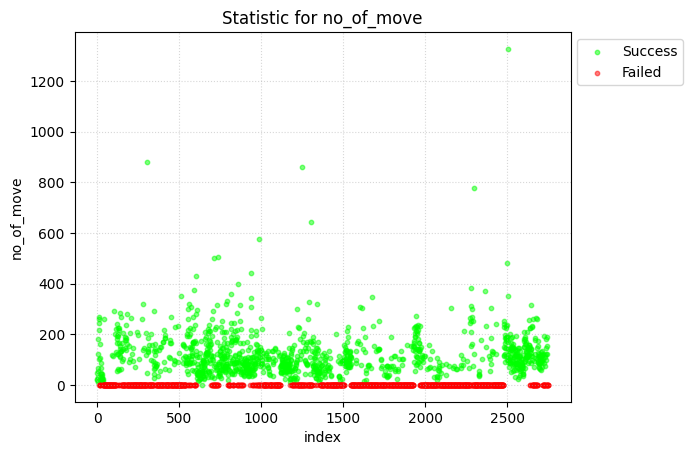

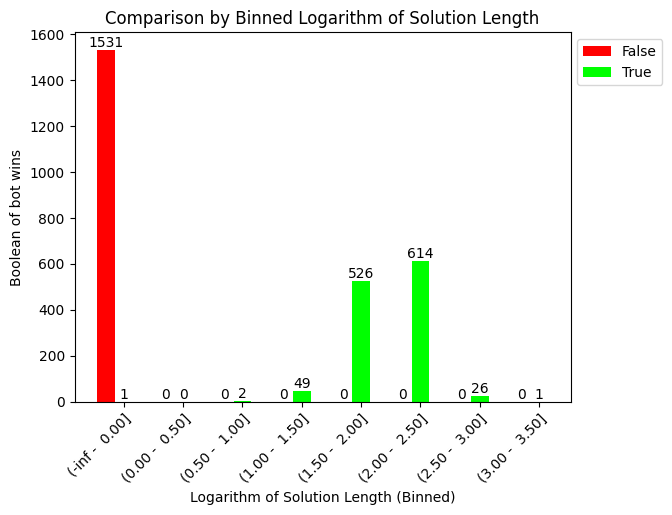

In [262]:


# Create custom function for this section
def generate_comparison_graphs_of_wins(info_type: str):
  generate_normal_scatter(df_sucessful, info_type, COLORS["GREEN"])
  generate_normal_scatter(df_failed, info_type, COLORS["RED"])
  plt.legend(['Success', "Failed"], loc='upper left', bbox_to_anchor=(1, 1))
  plt.grid(linestyle=':', alpha=0.5)
  plt.show()

no_of_move_bins = [-math.inf, 0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5]
generate_comparison_graphs_of_wins("no_of_move") 
graph_binned_bar(df, 
                info_type = "log_no_of_move", group_type = "has_bot_won", 
                bins = no_of_move_bins, 
                colors=[COLORS["RED"], COLORS["GREEN"]]
                )

### Time Taken to Solve
> "The more time a bot needs to solve a problem, the less likely a map it is solvable given the time limit. An increase of difficulty of a map would naturally take longer to process."

The average time for the sokobot to find a solution in a solvable map is around 1.6 with a standard deviation of 3.0. 

In [263]:
print_avg_std(df_sucessful, "time_taken")

Time taken to solve
Mean               : 1.6671780147662019
Standard Deviation : 3.011329440952362




The figure belows shows the time taken to solve for every map grouped by those the bot has succeded to solve and those failed. 

The figure below shows that most maps where the sokobot failed is stuck at the 15.0 seconds time limit. The other few red dots represent when there is no solution to be found.

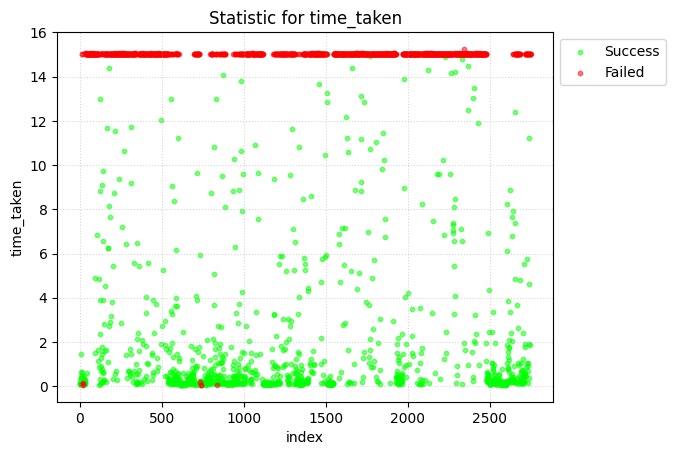

In [264]:
generate_comparison_graphs_of_wins("time_taken")

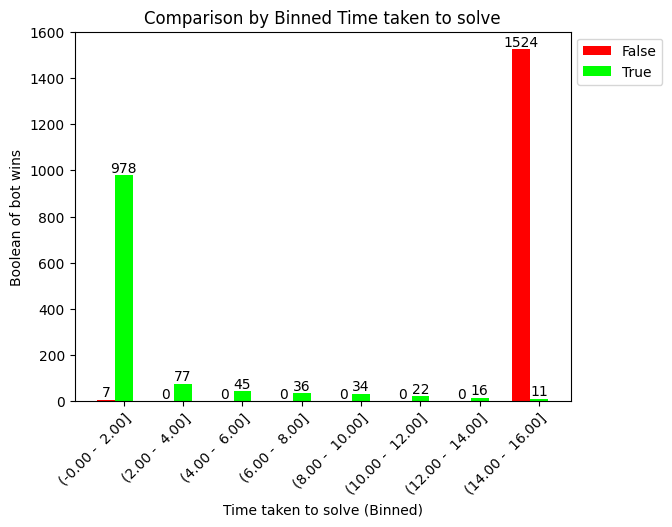

In [265]:
graph_binned_bar(df, 
                info_type = "time_taken", group_type = "has_bot_won", 
                bins = [0, 2, 4, 6, 8, 10, 12, 14, 16], 
                colors=[COLORS["RED"], COLORS["GREEN"]]
                )

### New nodes created and processed
> "The more information the bot needs to solve and process, the farther the goal is from the time limit."

Failed maps are interesting to note for node creation and processing, for they are in certain range of values for nodes created and processed.


The logarithm of the child nodes created, or more intuitively its **the order of magnitude**, seems to be around 6 to 6.5. 
Looking back at the original dataset, the failed dataset have child nodes produced at range from 1.0 to 2.5 millions nodes. 


This is an indicator that some hard maps require more moves to process and to find the solution. Since there is a limited time, it may give rise to place a boundary of amount of nodes to create and process within that 15.0 time limit.

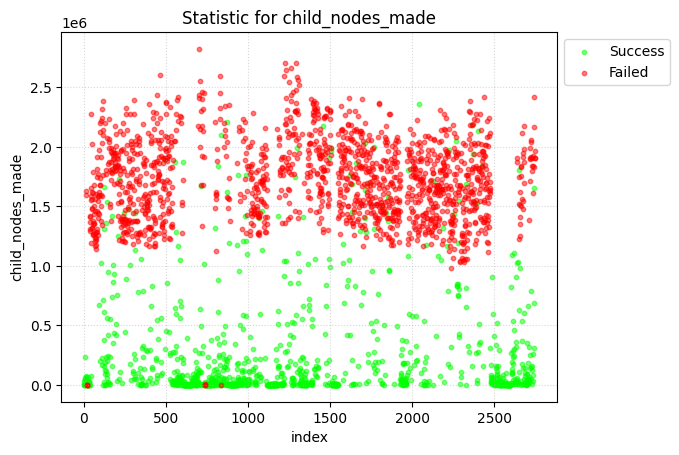

In [266]:
generate_comparison_graphs_of_wins("child_nodes_made")

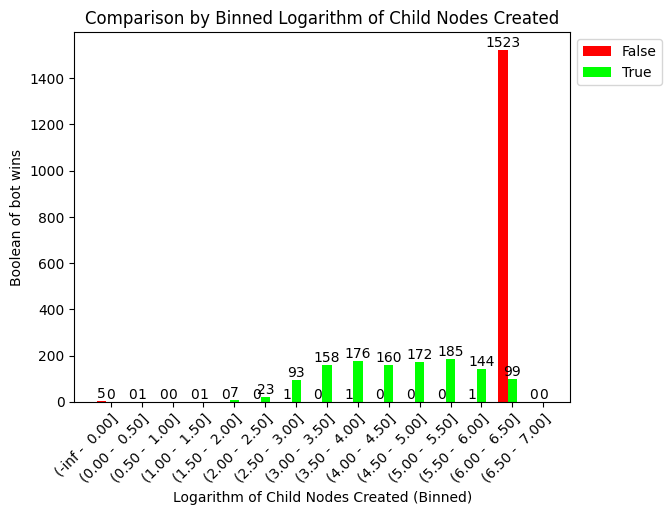

In [267]:

nodes_expanded_bins = [-math.inf, 0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7]
graph_binned_bar(df, 
                info_type = "log_child_nodes_made", group_type = "has_bot_won", 
                bins = nodes_expanded_bins, 
                colors=[COLORS["RED"], COLORS["GREEN"]]
                )

The nodes proccessed by the sokobot for a given map ranges from 0.7 to 2.0 million. The order of magnitude is around 6 to 6.5.

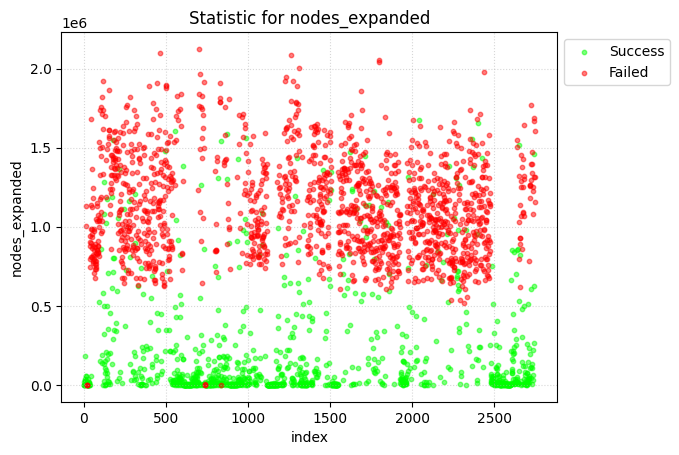

In [268]:
generate_comparison_graphs_of_wins("nodes_expanded")

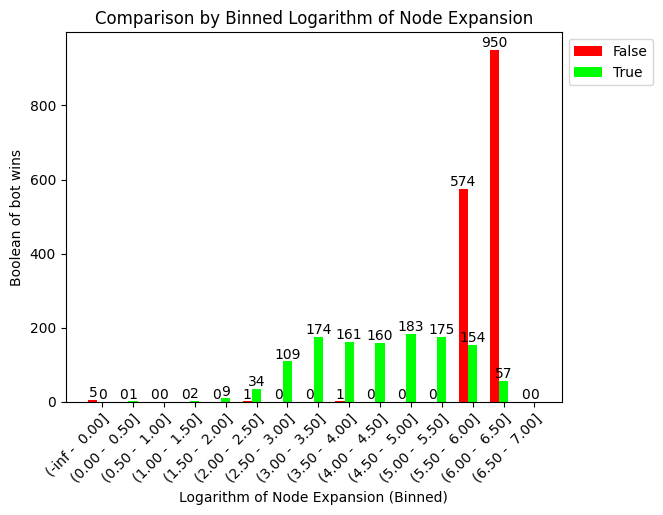

In [269]:

nodes_expanded_bins = [-math.inf, 0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7]
graph_binned_bar(df, 
                info_type = "log_nodes_expanded", group_type = "has_bot_won", 
                bins = nodes_expanded_bins, 
                colors=[COLORS["RED"], COLORS["GREEN"]]
                )

### Crate Count

> "Increasing crate count increases difficulty to solve as you have more goals to keep track of to win."

The figure below displays the percentage of maps completed as the number of crates increases. The number of maps complete sharply decreases as the number of boxes increases.

<Figure size 640x480 with 0 Axes>

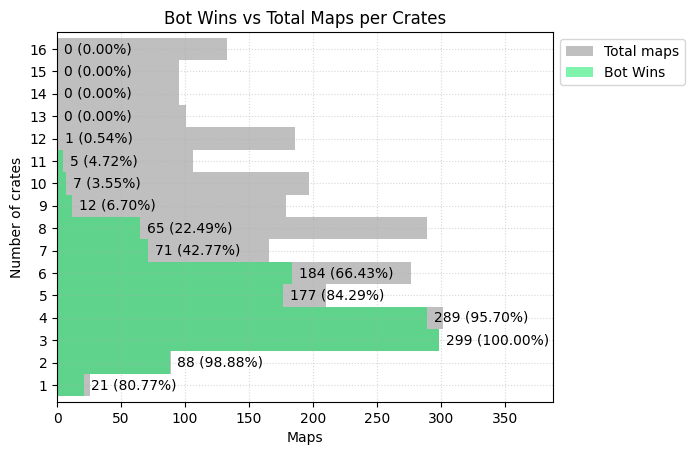

In [270]:
# Custom function that breaks the graphing process further.
def generate_percentage_annotations(pivot_table_partial, pivot_table_total, value_col_name, ax)->list:
    # Adding labels on top of the 'sum_of_wins' bars
    annotations = []
    
    for (index, series_partial), (_, series_total) in zip(pivot_table_partial.iterrows(), pivot_table_total.iterrows()):
        # Get the actual data
        partial = series_partial[value_col_name]
        total = series_total[value_col_name]
        
        percent = calculate_percent(partial, total)
        
        # Create an annotation placed on the right of the bar graph
        annotation = ax.annotate(f'{int(partial)} ({percent:.2f}%)', 
                    xy=(percent*total / 100, index-1),  # Use partial if no second graph, else get the actual percentage from the bigger graph
                    xytext=(5, 0),
                    va='center',
                    ha='left',
                    textcoords='offset points')
        annotations.append(annotation)
    return annotations;

def print_percentage_stats(pivot_table_partial, pivot_table_total, groupby_col_name, value_col_name) -> None:
    essay_total_wins_per_total_maps = ["Win percentage of maps per crate count:\n"]

    for (no_of_groupby, series_total_maps), (_, series_no_of_wins_series) in zip(pivot_table_total.iterrows(), pivot_table_partial.iterrows()):
        no_of_wins = series_no_of_wins_series[value_col_name]
        total_maps = series_total_maps[value_col_name]
        
        percent = (0, no_of_wins/total_maps * 100)[total_maps > 0]
        essay_total_wins_per_total_maps.append(f'{INFO_NICKNAMES[groupby_col_name]}: {no_of_groupby}, {INFO_NICKNAMES[value_col_name]} \\ total_maps: {no_of_wins}/{total_maps}')
        essay_total_wins_per_total_maps.append(f'{str_percentage_bar(partial=no_of_wins, total=total_maps)}\n')

    print_essay(essay_total_wins_per_total_maps)

def generate_won_pivot_table_bar_plot(df, groupby_name:str ='no_of_crates', value_col_name:str = 'has_bot_won', has_to_print_console: bool = True):
    # Count has_bot_won per crate count
    pt_cc_total_maps = df.pivot_table(index=groupby_name, values=value_col_name, aggfunc='count')

    # Sum the true has_bot_won per crate count
    pt_cc_has_won = df.pivot_table(index=groupby_name, values=value_col_name, aggfunc='sum')

    if has_to_print_console:
        print_percentage_stats(pt_cc_has_won, pt_cc_total_maps, groupby_name, value_col_name)

    # Plotting both the total maps and wins on the same graph
    fig = plt.figure()
    ax = pt_cc_total_maps.plot(kind='barh', legend=False, alpha=0.5, color='gray', width=1)

    annotations = generate_percentage_annotations(pt_cc_has_won, pt_cc_total_maps, value_col_name, ax)

    # Plot on the same axis
    pt_cc_has_won.plot(kind='barh', ax=ax, color=f'{INFO_COLORS[value_col_name]}', alpha=0.5, width=1)

    plt.title(f'{INFO_NICKNAMES[value_col_name]} vs Total Maps per {INFO_NICKNAMES[groupby_name]}')
    plt.xlabel('Maps')
    plt.ylabel(f'{INFO_NAMES[groupby_name]}')
    plt.legend(['Total maps', INFO_NICKNAMES[value_col_name]], loc='upper left', bbox_to_anchor=(1, 1))
    plt.grid(linestyle=':', alpha=0.5)
    
    # Show the updated plot
    plt.draw()
    adjust_scatter_annotations(annotations)

generate_won_pivot_table_bar_plot(df, has_to_print_console=False)


### Map size
> "Increasing the map size increases the amount of tiles needed to be account by the program. Although, it is moderate correlation."

Taking the logarithm of the map size has produced these interesting gaussian distributions. Most solvable maps are a size of 10^4.37 or 23,442 tiles squared, while most unsolvable ones are around 1e6 tiles squared.

In [271]:

print("Succesful solvable maps:")
df_sucessful["log_map_size"] = df_sucessful["map_size"].agg(math.log)
print_avg_std(df_sucessful, "log_map_size")
print("Failed maps:")
df_failed["log_map_size"] = df_failed["map_size"].agg(math.log)
print_avg_std(df_failed, "log_map_size")

Succesful solvable maps:
Logarithm of Map Size
Mean               : 4.365547731811752
Standard Deviation : 0.36521650982379594

Failed maps:
Logarithm of Map Size
Mean               : 5.001310179142602
Standard Deviation : 0.43523170713026



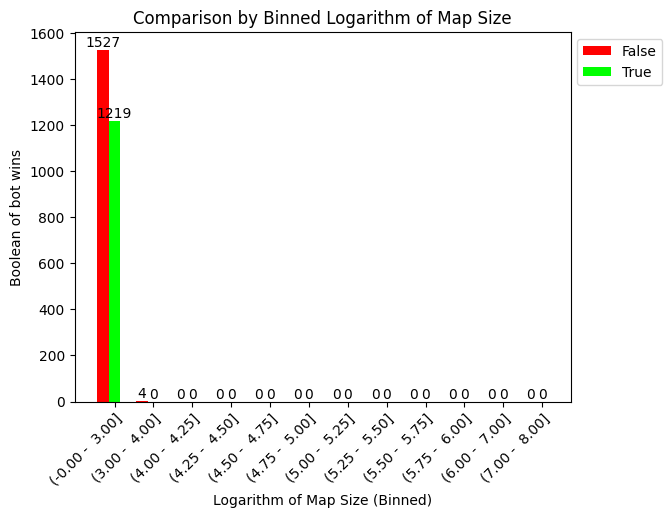

In [272]:
map_size_bins = [0, 3, 4, 4.25, 4.5, 4.75, 5, 5.25, 5.5, 5.75, 6, 7, 8]
graph_binned_bar(df, 
                info_type = "log_map_size", group_type = "has_bot_won", 
                bins = map_size_bins, 
                colors=[COLORS["RED"], COLORS["GREEN"]]
                )

# Time taken to solve
  - Node Created
  - Node Processed

## Branching Factor
The branching factor is 

In [273]:
essay_overall_branch_factor = [
    "What is the estimated weighted average for the branching factor for sokobot?",
    "Overall Branching factor: {}".format(round(df["branching_factor"].agg("mean"), 2))
]
print_essay(essay_overall_branch_factor)
display(Math(r'B_{o} = {%f}' % (df["branching_factor"].agg("mean"))))

essay_winning_factor = [
    f"For tests that are {colored_text(COLORS["GREEN"])}solvable in 15.0 seconds{RESET_COLORS}, what is the branching factor?",
    "Wins Branching factor: {}".format(round(df_sucessful["branching_factor"].agg("mean"), 2))
]
print_essay(essay_winning_factor)
display(Math(r'B_{w} = {%f}' % (df_sucessful["branching_factor"].agg("mean"))))


essay_failing_factor_factor = [
    f"For tests that {colored_text(COLORS["RED"])}failed{RESET_COLORS}, what is the branching factor?",
    "Fail Branching factor: {}".format(round(df_failed["branching_factor"].agg("mean"), 2))
]
print_essay(essay_failing_factor_factor)
display(Math(r'B_{l} = {%f}' % (df_failed["branching_factor"].agg("mean"))))



What is the estimated weighted average for the branching factor for sokobot?
Overall Branching factor: 1.44


<IPython.core.display.Math object>


For tests that are solvable in 15.0 seconds, what is the branching factor?
Wins Branching factor: 1.29


<IPython.core.display.Math object>


For tests that failed, what is the branching factor?
Fail Branching factor: 1.56


<IPython.core.display.Math object>

How does time to solve correlate with the number of crates?

Time taken to solve for each increase in the number of crates:


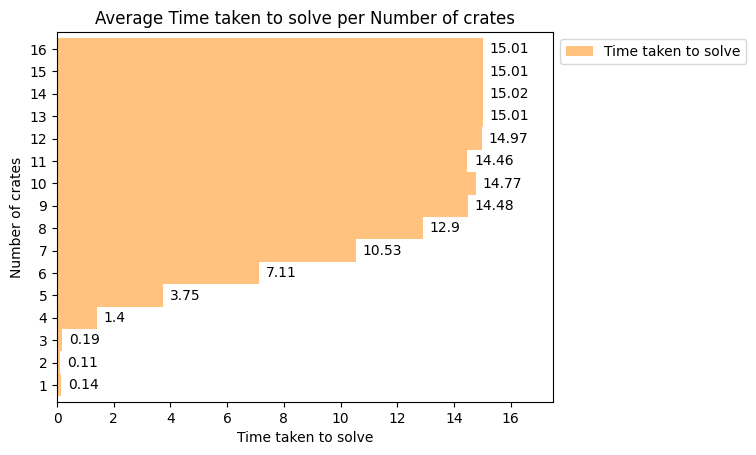

In [274]:
print("Time taken to solve for each increase in the number of crates:")
groupby_bar_plot(df, "no_of_crates", "time_taken")

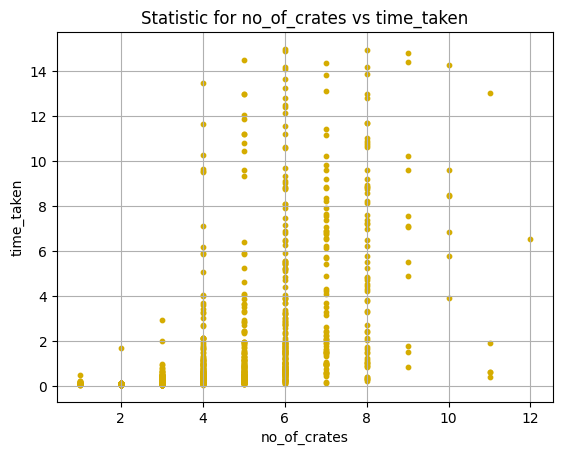

In [275]:
genenerate_tuple_scatter(df_sucessful, ("no_of_crates", "time_taken"))

time_taken     1.667178
map_density    1.378785
dtype: float64

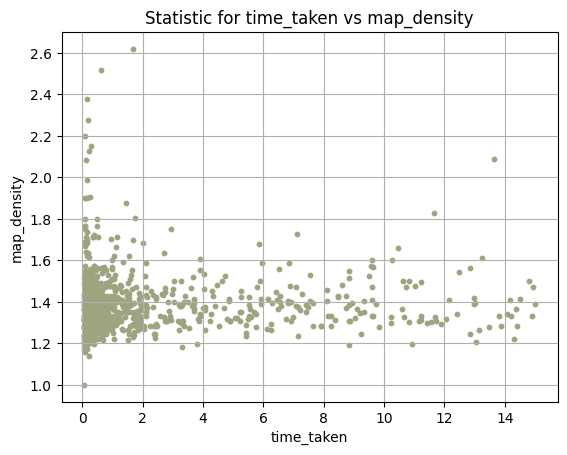

In [276]:
genenerate_tuple_scatter(df_sucessful, ("time_taken", "map_density"))
df_sucessful[["time_taken", "map_density"]].agg('mean')


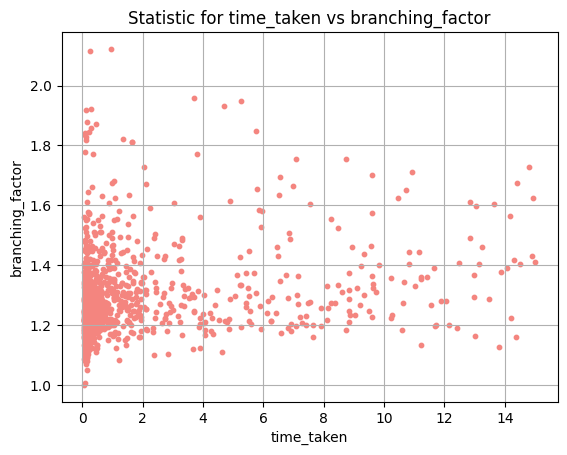

In [277]:
genenerate_tuple_scatter(df_sucessful, ("time_taken", "branching_factor"))

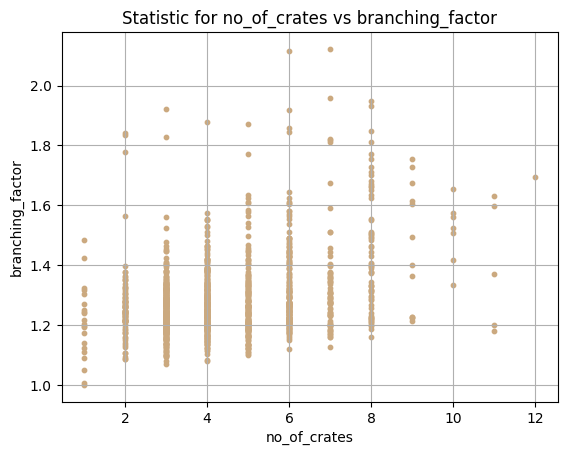

In [278]:
genenerate_tuple_scatter(df_sucessful, ("no_of_crates", "branching_factor"))

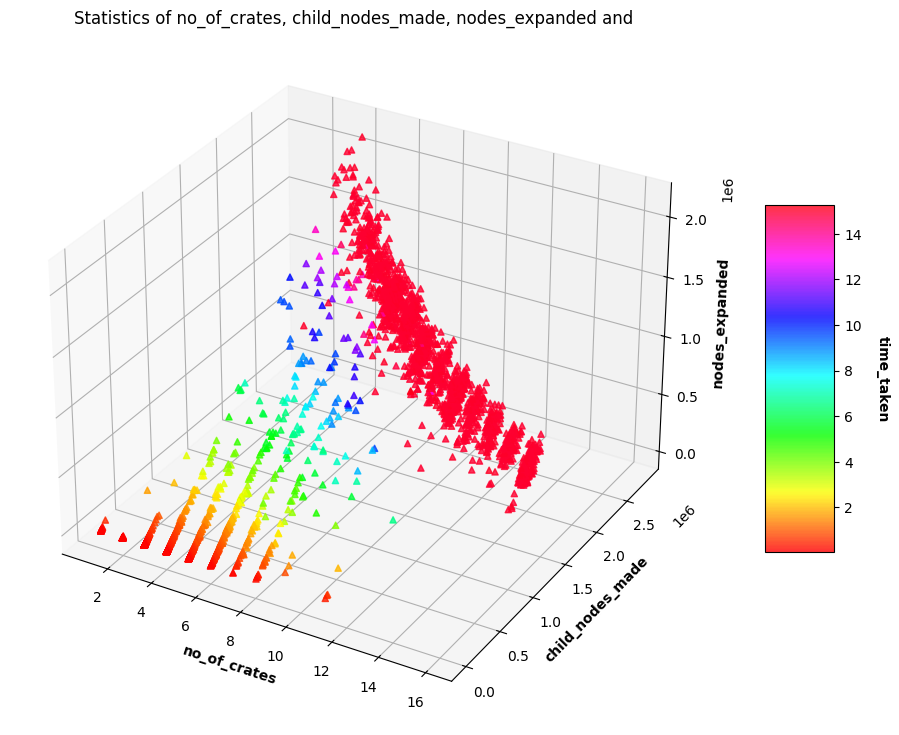

In [279]:


generate_3d_scatter(df, ("no_of_crates", "child_nodes_made", "nodes_expanded"), "time_taken")

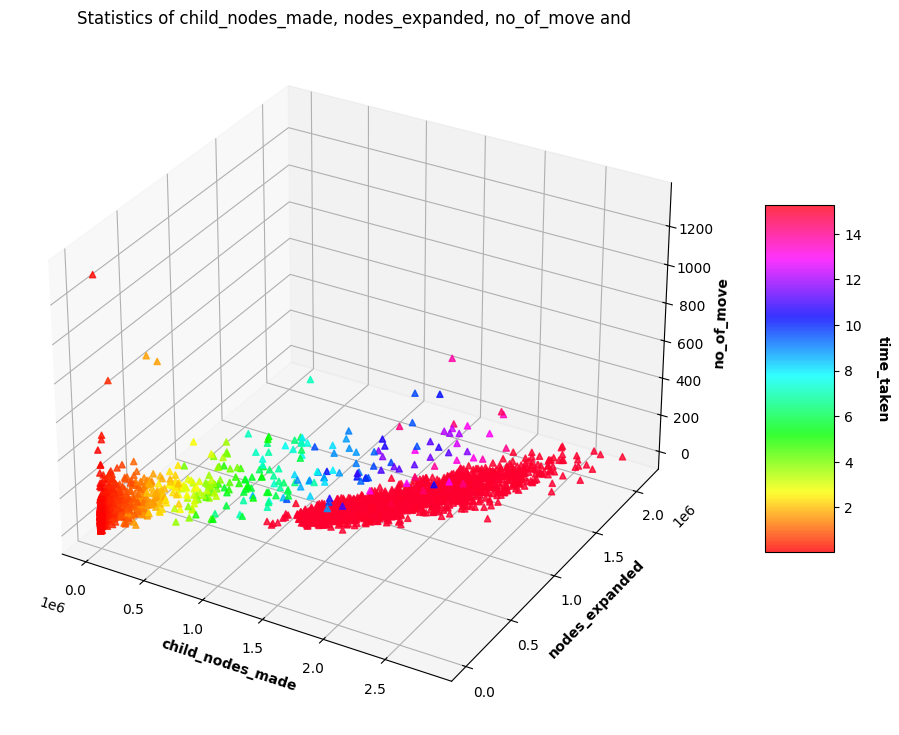

In [280]:
generate_3d_scatter(df, ("child_nodes_made", "nodes_expanded", "no_of_move"), "time_taken")

In [281]:
plt.show()

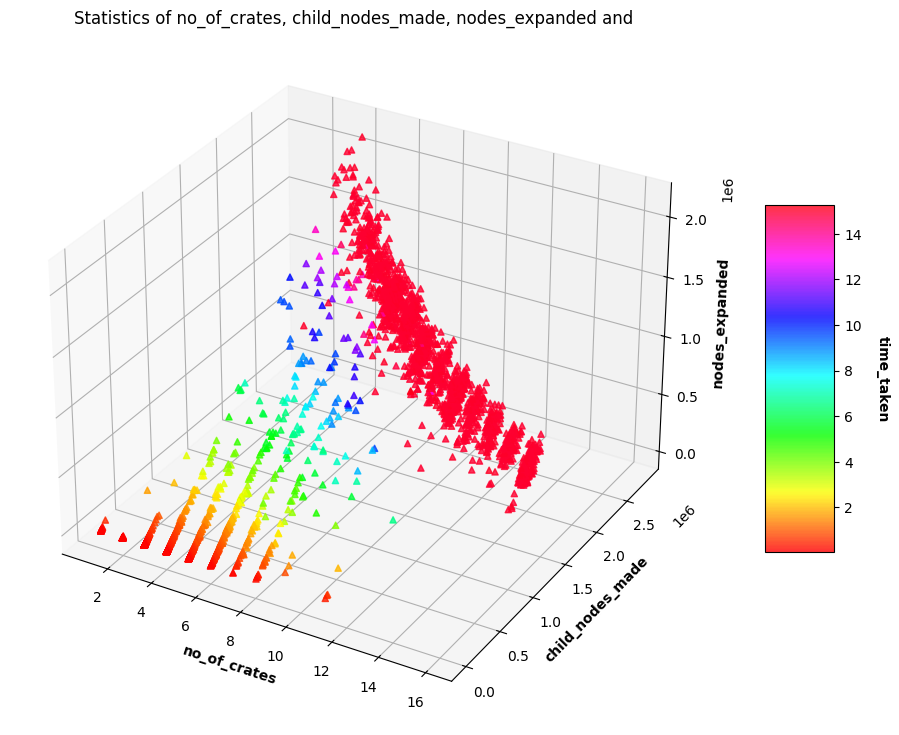

In [282]:
"""Generate 3d scatter plot based on three Series, with the possible inclusion of a fourth one by domain coloring

Args:
    df (pd.DataFrame): 
    tuple_col (tuple[str, str, str]):  tuple of strings that represent the names of series for (x, y, z) values.
    cmap_col (str, optional): string of the name of the series to do domain coloring. Defaults to "".
"""

x = df["no_of_crates"]
y = df["child_nodes_made"]
z = df["nodes_expanded"]
w = df["time_taken"]

# Creating figure
fig = plt.figure(figsize = (16, 9))
ax  = plt.axes(projection ="3d")

# Add x, y gridlines 
ax.grid(
    b = True, 
    color ='grey', 
    linestyle ='-.', 
    linewidth = 0.3, 
    alpha = 0.2
) 

# Creating color map
my_cmap = plt.get_cmap('hsv')


# Creating plot
sctt = ax.scatter3D(x, y, z,
                alpha = 0.8,
                c = w, 
                cmap = my_cmap, 
                marker ='^')

plt.title("Statistics of {}, {}, {} and ".format("no_of_crates", "child_nodes_made", "nodes_expanded"))
ax.set_xlabel("no_of_crates", fontweight ='bold') 
ax.set_ylabel("child_nodes_made", fontweight ='bold') 
ax.set_zlabel("nodes_expanded", fontweight ='bold')

# Label the color bar
cbar = fig.colorbar(sctt, ax=ax, shrink=0.5, aspect=5)
cbar.set_label("time_taken", rotation=270, labelpad=20, fontweight='bold')  

# show plot
plt.grid()